This code is under MIT license. See the License.txt file.

## Loading the libraries and dependencies

In [2]:
## Libraries ##
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import time as libtime
import seaborn as sns; sns.set()
from decimal import Decimal
import gc
plt.style.use('default')

## Home made function
from Main import *                    ## The model per se
from Numerical_functions import *     ## Few helpful functions

## Bifurcation

In [16]:
### Here is a description of the parameters of interest of the model:
"""
Cell:
- rc     : cell radius
- Vc     : cell volume
- Qc     : structural biomass of the cell (depends on rc)

Reproduction and death:
- gmax   : maximum of g, the division rate (of a sigmoïd function of the log-internal state of the cell)
- thresh : inflexion point of g, the rate, at which g=gmax/2 (depends on rc)
- slope  : slope in of g at g(thresh)
- kd     : maximum metabolism related decay rate (when metabolism is insufficient to fuel cell maintenance; see below)
- mort   : intrinsic metabolic rate, can be seen as a senescence term or an accidental death term. 

Metabolism:
- qmax   : maximum metabolic rate (Michaelis-Menten; depends on rc)
- ks     : half-saturation constant of the metabolism (Michaelis-Menten)
- mg     : minimum metabolic rate to fulfill the energetic requirement for cell maintainance (depends on rc)

Environment:
- QH, QC, QN, QG : inward/outward fluxes constants. From SBL (diffusion and solubilisation) for H2 (H), CO2 (C), and CH4 (G).
           From hydrothermal vents for NH4 (N). 
- Hinf, Cinf, Ninf, Ginf : abiotic equilibrium values (fixed for the moment assuming no feedback onto 
           atmospheric composition). Equals to 0 for Xo (the dead biomass)
- Still need a term describing the externalization of Xo (dead biomass). For the moment it is described by a constant 
  (burrial?).
"""

### Default parametrization
## t is time (...):
tmax        = 1000                     
dt          = 0.0025                     

## Trait
rc         = 1e-6                     # µm
Vc         = (4/3)*pi*rc**3           # µm3
Qc         = (18E-12*Vc**(0.94))/10   # molX.Cell-1       Menden-Deuer and Lessard 2000
ks         = 1e-12                    # molX.L-1          arbitrary
qmax       = 1e-1                     # (d.(molX.L-1))-1  Gonzalez Cabaleiro 2015 PLOS
qmax       = qmax*Qc/Vc               # (d.Cell)-1
mg         = 4500                     # J.(molX.h-1)      Gonzalez Cabaleiro 2015 PLOS
mg         = 4500*24*Qc               # J.(Cell.d-1) 
kd         = 1                        # d-1               Batstone et al 2002 in GC 2015 ISME
mort       = 0.1                      # d-1               arbitrary 
thresh     = 10*Qc                    # molX.Cell-1       arbitrary
slope      = 10                       #                   arbitrary 
gmax       = 1                        # d-1               arbitrary

## Environment (more details in Environment.py)
QH         = 1.1e-1                   # m(x100).d-1       Kharecha
QC         = 4.1e-2                   # m(x100).d-1       Kharecha
QN         = 1E-6                     # m(x100).d-1       arbitrary
QG         = 3.9e-2                   # m(x100).d-1       Kharecha
Hinf       = 7.8e-7                   # mol.L-1           Kharecha
Cinf       = 2.5e-6                   # mol.L-1           Kharecha
Ninf       = 1e-8                     # mol.L-1           arbitrary
Ginf       = 1.4e-8                   # mol.L-1           Kharecha
    
### Vectors of parameter values explored during bifurcation:
"""
qmax_vec    = np.exp(np.arange(np.log(1E-2),np.log(1E1),(np.log(1E1)-np.log(1E-2))/200))*Qc/Vc 
qmax_vec    = list(reversed(qmax_vec))
ks_vec      = np.exp(np.arange(np.log(1E-6),np.log(4E-4),(np.log(4E-4)-np.log(1E-6))/100)) 
ks_vec      = list(reversed(ks_vec))
ks_vec      = np.exp(np.arange(np.log(1E-10),np.log(1E5),(np.log(1E5)-np.log(1E-10))/200)) 
#ks_vec     = list(reversed(ks_vec))
gmax_vec    = np.exp(np.arange(np.log(1E-1),np.log(3E0),(np.log(3E0)-np.log(1E-1))/200)) 
gmax_vec    = list(reversed(gmax_vec))
thresh_vec  = np.exp(np.arange(np.log(8E-13),np.log(8E-9),(np.log(8E-9)-np.log(8E-13))/100)) 
#thresh_vec = list(reversed(gmax_vec))
Hinf_vec    = np.exp(np.arange(np.log(1E-9),np.log(1E-5),(np.log(1E-5)-np.log(1E-9))/100))
Hinf_vec    = list(reversed(Hinf_vec))
Cinf_vec    = np.exp(np.arange(np.log(8E-10),np.log(1E15),(np.log(1E15)-np.log(8E-10))/200))
#Cinf_vec   = list(reversed(Cinf_vec))
kd_vec      = np.exp(np.arange(np.log(9E-1),np.log(1E2),(np.log(1E2)-np.log(9E-1))/100)) 
#kd_vec     = list(reversed(kd_vec))
mort_vec    = np.exp(np.arange(np.log(1E-2),np.log(0.9),(np.log(0.9)-np.log(1E-2))/200)) 
#mort_vec   = list(reversed(mort_vec))
rc_vec      = np.exp(np.arange(np.log(1E-7),np.log(1E-3),(np.log(1E-3)-np.log(1E-7))/20))
rc_vec      = list(reversed(rc_vec))  # Choose if the bifurcation is upward or downward  
"""

### Vector of the bifurcation actually performed
Hinf_vec    = np.exp(np.arange(np.log(1E-9),np.log(1E-5),(np.log(1E-5)-np.log(1E-9))/100))
Hinf_vec    = list(reversed(Hinf_vec))
par_vec     = gmax_vec

### Arrays storing the results of the bifurcation
NC_mat      = []
X_mat       = []
H_mat       = []
C_mat       = []
N_mat       = []
G_mat       = []
Xo_mat      = []

i = 0
init = [Hinf,Cinf,1e2,1E-10,0,1e4,thresh]
#init = [Hinf,par_vec[i],1e2,1E-10,0,1e4,thresh]  ## to use when the bifurcation is performed on an environmental parameter 

for i in range(0,len(par_vec)):
    
    gmax       = par_vec[i]               # Replace by the parameter on which the bifurcation is performed
    
    ## switch-off the parameter on which the bifurcation is performed
    rc         = 1e-6                     # µm
    Vc         = (4/3)*pi*rc**3           # µm3 
    Qc         = (18E-12*Vc**(0.94))/10   # molX.Cell-1       Menden-Deuer and Lessard 2000
    ks         = 1e-12                    # molX.L-1          arbitrary
    qmax       = 1e-1                     # (d.(molX.L-1))-1  Gonzalez Cabaleiro 2015 PLOS
    qmax       = qmax*Qc/Vc               # (d.Cell)-1
    mg         = 4500                     # J.(molX.h-1)      Gonzalez Cabaleiro 2015 PLOS
    mg         = 4500*24*Qc               # J.(Cell.d-1) 
    kd         = 1                        # d-1               Batstone et al 2002 in GC 2015 ISME
    mort       = 0.1                      # d-1               arbitrary 
    thresh     = 10*Qc                    # molX.Cell-1       arbitrary
    slope      = 10                       #                   arbitrary 
    #gmax       = 1                        # d-1               arbitrary

    QH         = 1.1e-1                   # m(x100).d-1       Kharecha
    QC         = 4.1e-2                   # m(x100).d-1       Kharecha
    QN         = 1E-6                     # m(x100).d-1       arbitrary
    QG         = 3.9e-2                   # m(x100).d-1       Kharecha
    Hinf       = 7.8e-7                   # mol.L-1           Kharecha
    Cinf       = 2.5e-6                   # mol.L-1           Kharecha
    Ninf       = 1e-8                     # mol.L-1           arbitrary
    Ginf       = 1.4e-8                   # mol.L-1           Kharecha
    
    Env        = [Hinf,Cinf,Ninf,Ginf,QH,QC,QN,QG]
    starters   = [rc,Vc,Qc,ks,qmax,mg,kd,mort,thresh,slope,gmax]
    if i>0:
        tmax   = 100                     
        time   = np.arange(0,tmax,dt)    
    NCT,XT,HT,CT,NT,GT,XoT,D,time = Run_Profile(init,starters,Env,tmax=tmax,T=TS,dt = dt)
    NCT  = np.array(NCT)
    XT   = np.array(XT)
    HT   = np.array(HT)
    CT   = np.array(CT)
    NT   = np.array(NT)
    GT   = np.array(GT)
    XoT  = np.array(XoT)
    D    = np.array(D)

    NC_mat.append(NCT)
    X_mat.append(XT)
    H_mat.append(HT)
    C_mat.append(CT)
    N_mat.append(NT)
    G_mat.append(GT)
    Xo_mat.append(XoT)
    init = [HT[len(HT)-1],CT[len(CT)-1],max([NT[len(NT)-1],1E-1]),GT[len(GT)-1],XoT[len(XoT)-1],NCT[len(NCT)-1],max([Qc/10,XT[len(XT)-1]])]
    print("Progress => {:2.1%}".format((i+1)/len(par_vec)), end="\r")
gc.collect()

22306

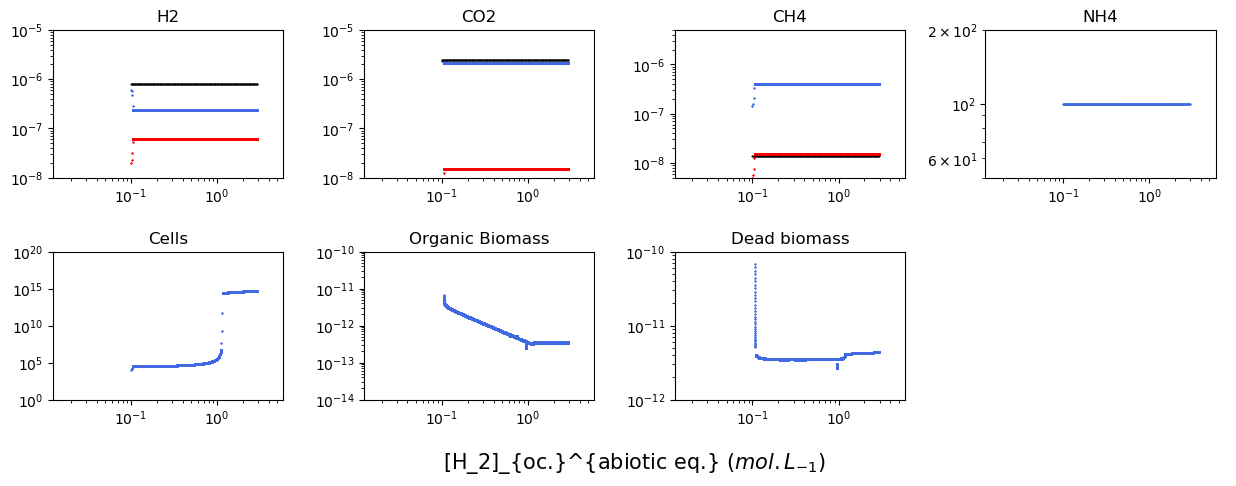

In [18]:
optNCT_array = []
for i in range(0,len(par_vec)):
    temp_NCT = NC_mat[i]
    endNCT   = temp_NCT[int(np.floor(len(temp_NCT))*0.5) : len(temp_NCT)]
    deltaNCT = diff(endNCT)
    optNCT   = np.abs(diff(np.sign(deltaNCT)))
    t_optNCT = find(optNCT,2)
    if not t_optNCT:
        t_optNCT = [len(endNCT)-3,len(endNCT)-3]
    optNCT   = endNCT[np.array(t_optNCT)+2]
    optNCT_array.append(optNCT)
    
optCT_array = []
for i in range(0,len(par_vec)):
    temp_CT = C_mat[i]
    endCT   = temp_CT[int(np.floor(len(temp_CT))*0.5) : len(temp_CT)]
    deltaCT = diff(endCT)
    optCT   = np.abs(diff(np.sign(deltaCT)))
    t_optCT = find(optCT,2)
    if not t_optCT:
        t_optCT = [len(endCT)-3,len(endCT)-3]
    optCT   = endCT[np.array(t_optCT)+2]
    optCT_array.append(optCT)
    
optHT_array = []
for i in range(0,len(par_vec)):
    temp_HT = H_mat[i]
    endHT   = temp_HT[int(np.floor(len(temp_HT))*0.5) : len(temp_HT)]
    deltaHT = diff(endHT)
    optHT   = np.abs(diff(np.sign(deltaHT)))
    t_optHT = find(optHT,2)
    if not t_optHT:
        t_optHT = [len(endHT)-3,len(endHT)-3]
    optHT   = endHT[np.array(t_optHT)+2]
    optHT_array.append(optHT)
    
optGT_array = []
for i in range(0,len(par_vec)):
    temp_GT = G_mat[i]
    endGT   = temp_GT[int(np.floor(len(temp_GT))*0.5) : len(temp_GT)]
    deltaGT = diff(endGT)
    optGT   = np.abs(diff(np.sign(deltaGT)))
    t_optGT = find(optGT,2)
    if not t_optGT:
        t_optGT = [len(endGT)-3,len(endGT)-3]
    optGT   = endGT[np.array(t_optGT)+2]
    optGT_array.append(optGT)
    
optXoT_array = []
for i in range(0,len(par_vec)):
    temp_XoT = Xo_mat[i]
    endXoT   = temp_XoT[int(np.floor(len(temp_XoT))*0.5) : len(temp_XoT)]
    deltaXoT = diff(endXoT)
    optXoT   = np.abs(diff(np.sign(deltaXoT)))
    t_optXoT = find(optXoT,2)
    if not t_optXoT:
        t_optXoT = [len(endXoT)-3,len(endXoT)-3]
    optXoT   = endXoT[np.array(t_optXoT)+2]
    optXoT_array.append(optXoT)
    
optXT_array = []
for i in range(0,len(par_vec)):
    temp_XT = X_mat[i]*NC_mat[i]
    endXT   = temp_XT[int(np.floor(len(temp_XT))*0.5) : len(temp_XT)]
    deltaXT = diff(endXT)
    optXT   = np.abs(diff(np.sign(deltaXT)))
    t_optXT = find(optXT,2)
    if not t_optXT:
        t_optXT = [len(endXT)-3,len(endXT)-3]
    optXT   = endXT[np.array(t_optXT)+2]
    optXT_array.append(optXT)
    
optNT_array = []
for i in range(0,len(par_vec)):
    temp_NT = N_mat[i]
    endNT   = temp_NT[int(np.floor(len(temp_NT))*0.5) : len(temp_NT)]
    deltaNT = diff(endNT)
    optNT   = np.abs(diff(np.sign(deltaNT)))
    t_optNT = find(optNT,2)
    if not t_optNT:
        t_optNT = [len(endNT)-3,len(endNT)-3]
    optNT   = endNT[np.array(t_optNT)+2]
    optNT_array.append(optNT)

fig, ax = plt.subplots(2,4,sharex=False)
for i in range(len(par_vec)):
    #Cinf = par_vec[i]
    ax[0,0].loglog([par_vec[i]]*len(optHT_array[i]),optHT_array[i],'.',color = 'royalblue', ms = 1, alpha = 1)
    ax[0,0].loglog([par_vec[i]]*len(optHT_array[i]),QH*(Hinf-optHT_array[i]),'.',color = 'red', ms = 1, alpha = 1)
    ax[0,0].loglog(par_vec[i],Hinf,'.',ms=1,color='black')
    ax[0,0].set_title('H2')
    ax[0,0].set_ylim([1E-8,1E-5])
    ax[0,0].set_xlim([min(par_vec)/8,max(par_vec)*2])

    ax[0,1].loglog([par_vec[i]]*len(optCT_array[i]),optCT_array[i],'.',color = 'royalblue', ms = 1, alpha = 1)
    ax[0,1].loglog([par_vec[i]]*len(optCT_array[i]),QC*(Cinf-optCT_array[i]),'.',color = 'red', ms = 1, alpha = 1)
    ax[0,1].loglog(par_vec[i],Cinf,'.',ms=1,color='black')
    ax[0,1].set_title('CO2')
    ax[0,1].set_ylim([1E-8,1E-5])
    ax[0,1].set_xlim([min(par_vec)/8,max(par_vec)*2])
    
    ax[0,2].loglog([par_vec[i]]*len(optGT_array[i]),optGT_array[i],'.',color = 'royalblue', ms = 1)
    ax[0,2].loglog([par_vec[i]]*len(optGT_array[i]),abs(QG*(Ginf-optGT_array[i])),'.',color = 'red', ms = 1)
    ax[0,2].loglog(par_vec[i],Ginf,'.',ms=1,color='black')
    ax[0,2].set_title('CH4')
    ax[0,2].set_ylim([5E-9,5E-6])
    ax[0,2].set_xlim([min(par_vec)/8,max(par_vec)*2])
    
    ax[0,3].loglog([par_vec[i]]*len(optNT_array[i]),optNT_array[i],'.',color = 'royalblue', ms = 1)
    ax[0,3].set_title('NH4')
    ax[0,3].set_ylim([5E1,2E2])
    ax[0,3].set_xlim([min(par_vec)/8,max(par_vec)*2])

    ax[1,0].loglog([par_vec[i]]*len(optNCT_array[i]),optNCT_array[i],'.',color = 'royalblue', ms = 1)
    ax[1,0].set_title('Cells')
    ax[1,0].set_ylim([1E0,1E20])
    ax[1,0].set_xlim([min(par_vec)/8,max(par_vec)*2])
    
    ax[1,1].loglog([par_vec[i]]*len(optXT_array[i]),optXT_array[i],'.',color = 'royalblue', ms = 1)
    ax[1,1].set_title('Organic Biomass')
    ax[1,1].set_ylim([1E-14,1E-10])
    ax[1,1].set_xlim([min(par_vec)/8,max(par_vec)*2])
  
    ax[1,2].loglog([par_vec[i]]*len(optXoT_array[i]),optXoT_array[i],'.',color = 'royalblue', ms = 1)
    ax[1,2].set_title('Dead biomass')
    ax[1,2].set_ylim([1E-12,1E-10])
    ax[1,2].set_xlim([min(par_vec)/8,max(par_vec)*2])
    
    ax[1,3].axis('off')
    ax[1,3].axes.get_xaxis().set_visible(False)
    
fig.subplots_adjust(hspace=0.5,wspace=0.35)
fig.set_figwidth(15)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.xlabel('$[H_2]_{oc.}^{abiotic eq.}$ ($mol.L_{-1}$)',labelpad=20,fontsize=15)

plt.savefig('Bif_gmax.png', dpi=500, format = 'png', transparent = True, bbox_inches='tight')
plt.show()


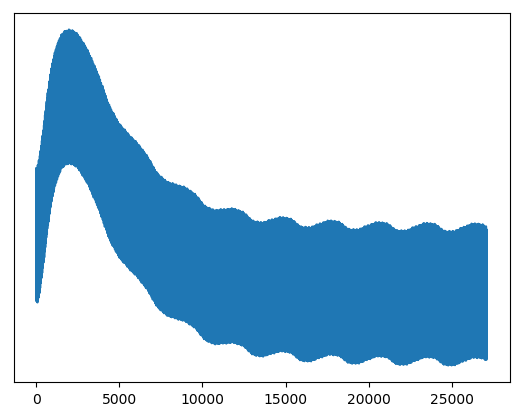

In [14]:
i = 50
plt.semilogy(Xo_mat[i])
plt.show()

In [5]:
np.where([1,3,2])

(array([0, 1, 2]),)